In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
import joblib


c:\Users\trdin\anaconda3\envs\tensor2\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
all_data = pd.read_csv("../data/raw/mbajk_dataset.csv")
print(all_data.head())

   Unnamed: 0                       date  temperature  relative_humidity  \
0           0  2023-06-25 19:07:30+00:00         25.1                 45   
1           1  2023-06-25 20:25:41+00:00         24.2                 43   
2           2  2023-06-25 20:12:20+00:00         24.2                 43   
3           3  2023-06-25 19:33:48+00:00         24.2                 43   
4           4  2023-06-25 19:55:29+00:00         24.2                 43   

   dew_point  apparent_temperature  precipitation_probability  rain  \
0       12.4                  24.7                        0.0   0.0   
1       10.9                  23.3                        NaN   0.0   
2       10.9                  23.3                        0.0   0.0   
3       10.9                  23.3                        0.0   0.0   
4       10.9                  23.3                        NaN   0.0   

   surface_pressure  bike_stands  available_bike_stands  
0             984.3           22                      8  


In [3]:
all_data['date'] = pd.to_datetime(all_data['date'])
all_data.sort_values(by='date', inplace=True)


In [4]:
all_data['date'] = pd.to_datetime(all_data['date'])
all_data.sort_values(by='date', inplace=True)
features = ['available_bike_stands', 'temperature', 'relative_humidity',
             'apparent_temperature', 'dew_point', 'precipitation_probability',
               'surface_pressure','bike_stands', 'rain']
all_data = all_data[['date'] + features]

In [5]:
all_data.isnull().sum()

date                            0
available_bike_stands           0
temperature                  1869
relative_humidity               0
apparent_temperature            0
dew_point                       0
precipitation_probability    1308
surface_pressure                0
bike_stands                     0
rain                         2804
dtype: int64

In [6]:
missing_values = all_data.isnull().sum()

print(missing_values)
features_with_missing_values = missing_values[missing_values > 0].index
    
all_data = all_data.copy()
columns_with_missing_values = all_data.columns[all_data.isnull().any()].tolist()
columns_complete_values = all_data.drop(columns_with_missing_values + ["date"], axis=1).columns.tolist()

missing_df = all_data[all_data.isnull().any(axis=1)]
complete_df = all_data.dropna()

for column in columns_with_missing_values:
    X = complete_df[columns_complete_values]
    y = complete_df[column]
    
    model = RandomForestRegressor()
    model.fit(X, y)
    
    missing_X = missing_df[columns_complete_values]
    predictions = model.predict(missing_X)
    
    all_data.loc[missing_df.index, column] = predictions

missing_values = all_data.isnull().sum()

print(missing_values)

multivariate_series = np.array(all_data[features].values)

date                            0
available_bike_stands           0
temperature                  1869
relative_humidity               0
apparent_temperature            0
dew_point                       0
precipitation_probability    1308
surface_pressure                0
bike_stands                     0
rain                         2804
dtype: int64
date                         0
available_bike_stands        0
temperature                  0
relative_humidity            0
apparent_temperature         0
dew_point                    0
precipitation_probability    0
surface_pressure             0
bike_stands                  0
rain                         0
dtype: int64


In [7]:
def plot_histograms(df):
    numeric_columns = df.select_dtypes(include=['number'])
    numeric_columns.hist(bins=20, figsize=(20, 20))
    plt.title("Histograms of numerical columns")
    plt.show()

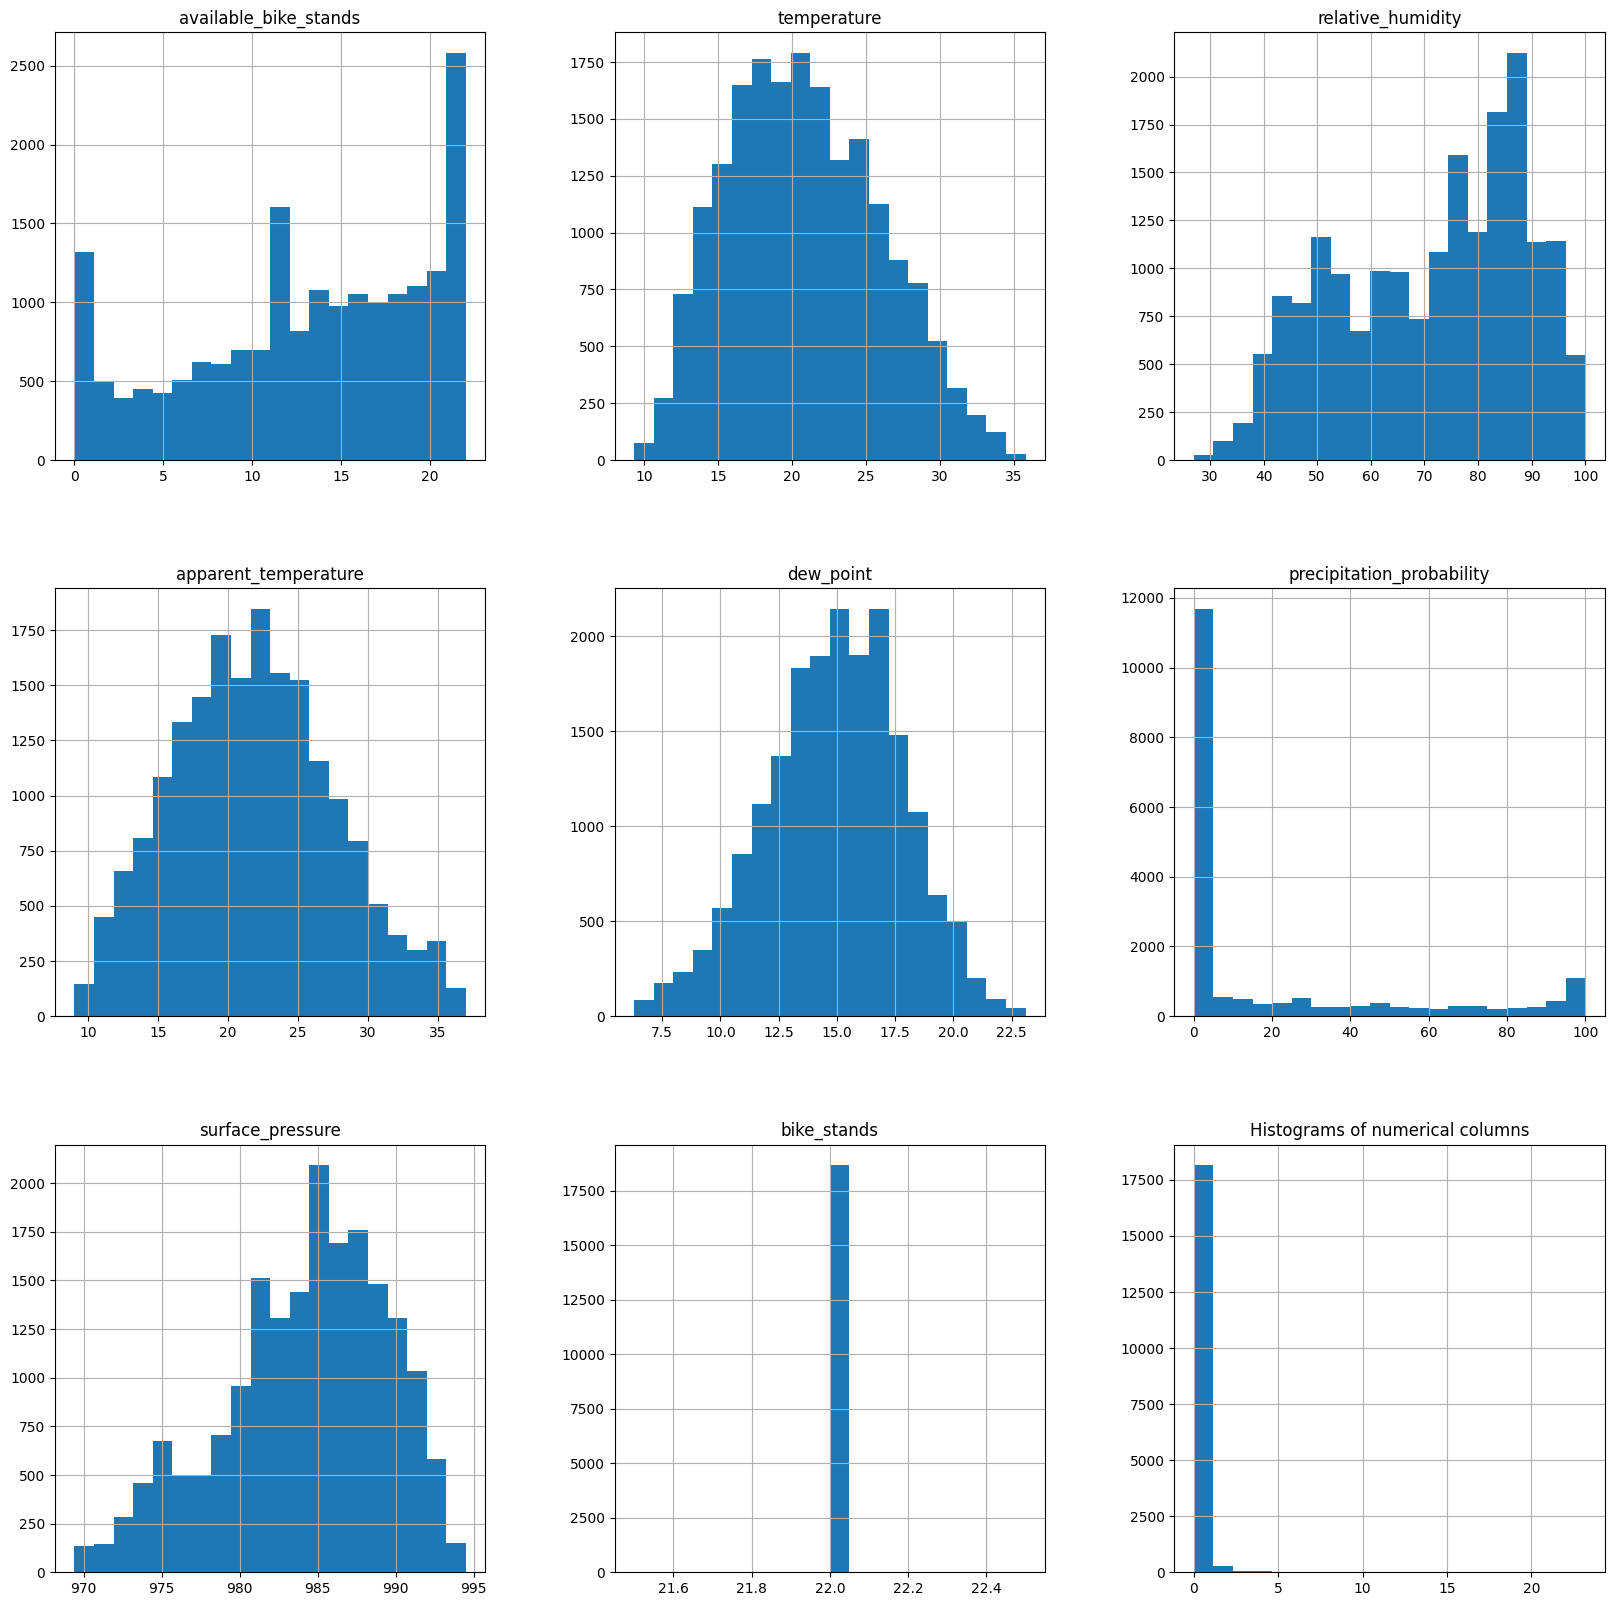

In [8]:
plot_histograms(all_data)

In [9]:
def printSkew():
  skewness_info = []
  for column in all_data.columns[1:]:
      skew = all_data[column].skew()
      skewness_info.append((column, skew))

  # Pretvori seznam v DataFrame za lažje prikazovanje
  skewness_df = pd.DataFrame(skewness_info, columns=['Column Name', 'Skewness'])

  # Izpišite oznako stolpca in njegovo poševnost
  print(skewness_df)

printSkew()

                 Column Name   Skewness
0      available_bike_stands  -0.457209
1                temperature   0.278238
2          relative_humidity  -0.364185
3       apparent_temperature   0.208651
4                  dew_point  -0.184927
5  precipitation_probability   1.417286
6           surface_pressure  -0.518403
7                bike_stands   0.000000
8                       rain  13.768873


In [10]:
left_skew_columns = ["surface_pressure"]
for col in left_skew_columns:
    all_data[col] = np.square(all_data[col])

In [11]:
right_skew_columns = ["rain", "precipitation_probability"]
for col in right_skew_columns:
    all_data[col] = np.log(all_data[col]+1 )

In [12]:
plot_histograms(all_data)


In [ ]:
target = all_data['available_bike_stands']
target_feature = all_data.drop('date', axis=1)

info_gains = mutual_info_regression(target_feature.drop('available_bike_stands', axis=1), target)

info_gain_df = pd.DataFrame({'Feature': target_feature.columns.drop('available_bike_stands'), 'Information_Gain': info_gains})
info_gain_df = info_gain_df.sort_values(by='Information_Gain', ascending=False)

print(info_gain_df)

threshold = 0.1
selected_features = info_gain_df[info_gain_df['Information_Gain'] >= threshold]['Feature']

print("Selected Features:")
print(selected_features)

                     Feature  Information_Gain
0                temperature          0.363057
2       apparent_temperature          0.348094
5           surface_pressure          0.344104
3                  dew_point          0.203401
4  precipitation_probability          0.195575
1          relative_humidity          0.120194
7                       rain          0.078026
6                bike_stands          0.000000
Selected Features:
0                  temperature
2         apparent_temperature
5             surface_pressure
3                    dew_point
4    precipitation_probability
1            relative_humidity
Name: Feature, dtype: object


In [ ]:
selected_features

In [ ]:
learn_features = all_data[ ['available_bike_stands']+ list(selected_features)]
learn_features = learn_features.values

In [ ]:
train_size = len(learn_features) - 576 - 48
train_data, test_data = learn_features[:train_size], learn_features[train_size:]


In [ ]:
train_data.shape, test_data.shape

((18068, 7), (624, 7))

In [ ]:
train_stands = np.array(train_data[:,0])
test_stands = np.array(test_data[:,0])
stands_scaler = MinMaxScaler()
train_stands_normalized = stands_scaler.fit_transform(train_stands.reshape(-1, 1))
test_stands_normalized = stands_scaler.transform(test_stands.reshape(-1, 1))

train_final_stands = np.array(learn_features[:, 0])
train_final_stands_normalized = stands_scaler.fit_transform(train_final_stands.reshape(-1, 1))

In [ ]:
train_other = np.array(train_data[:,1:])
test_other = np.array(test_data[:,1:])
other_scaler = MinMaxScaler()
train_other_normalized = other_scaler.fit_transform(train_other)
test_other_normalized = other_scaler.transform(test_other)

train_final_other = np.array(learn_features[:, 1:])
train_final_other_normalized = other_scaler.fit_transform(train_final_other)


In [ ]:
train_normalized = np.column_stack([train_stands_normalized, train_other_normalized])
test_normalized = np.column_stack([test_stands_normalized, test_other_normalized])

train_final_normalized = np.column_stack([train_final_stands_normalized, train_final_other_normalized])

In [ ]:
def create_multivariate_dataset_with_steps(time_series, look_back=1, step=1):
    X, y = [], []
    for i in range(0, len(time_series) - look_back, step):
        X.append(time_series[i:(i + look_back), :])
        y.append(time_series[i + look_back, 0]) 
    return np.array(X), np.array(y)

look_back = 48
step = 1

X_train, y_train = create_multivariate_dataset_with_steps(train_normalized, look_back, step)
X_test, y_test = create_multivariate_dataset_with_steps(test_normalized, look_back, step)

X_final, y_final = create_multivariate_dataset_with_steps(train_final_normalized, look_back, step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[2], X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2], X_test.shape[1])

X_final = X_final.reshape(X_final.shape[0], X_final.shape[2], X_final.shape[1])


print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (18020, 7, 48)
X_test shape: (576, 7, 48)


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=32))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1))
    return model

In [ ]:
def train_and_plot_model(model, X_train, y_train, epochs=50):
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.2, verbose=1)
    
    # Izris zgodovine učenja
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Learning History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])

Epoch 1/30
451/451 [==============================] - 6s 8ms/step - loss: 0.0356 - val_loss: 0.0088
Epoch 2/30
451/451 [==============================] - 3s 7ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 3/30
451/451 [==============================] - 3s 7ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 4/30
451/451 [==============================] - 3s 7ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 5/30
451/451 [==============================] - 3s 7ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 6/30
451/451 [==============================] - 3s 7ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 7/30
451/451 [==============================] - 3s 8ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 8/30
451/451 [==============================] - 3s 8ms/step - loss: 0.0028 - val_loss: 0.0033
Epoch 9/30
451/451 [==============================] - 3s 8ms/step - loss: 0.0027 - val_loss: 0.0033
Epoch 10/30
451/451 [==============================] - 3s 7ms/step - loss: 0.0027 - val_loss: 0.0034

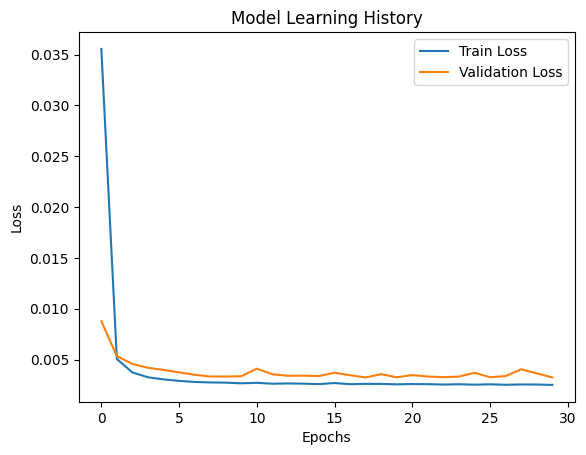

In [ ]:
lstm_model_adv = build_lstm_model(input_shape)
train_and_plot_model(lstm_model_adv, X_train, y_train, epochs=30)

In [ ]:
y_test_pred_lstm_adv = lstm_model_adv.predict(X_test)

18/18 [==============================] - 1s 3ms/step


In [ ]:
y_test_true = stands_scaler.inverse_transform(y_test.reshape(-1, 1))

y_test_pred_lstm_adv = stands_scaler.inverse_transform(y_test_pred_lstm_adv)

In [ ]:
def calculate_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    return mae, mse, evs

In [ ]:
lstm_mae_adv, lstm_mse_adv, lstm_evs_adv = calculate_metrics(y_test_true, y_test_pred_lstm_adv)
print("\nLSTM Model Metrics:")
print(f"MAE: {lstm_mae_adv}, MSE: {lstm_mse_adv}, EVS: {lstm_evs_adv}")


LSTM Model Metrics:
MAE: 1.4111075665568933, MSE: 4.195479103720107, EVS: 0.9125444804839451


(576,)


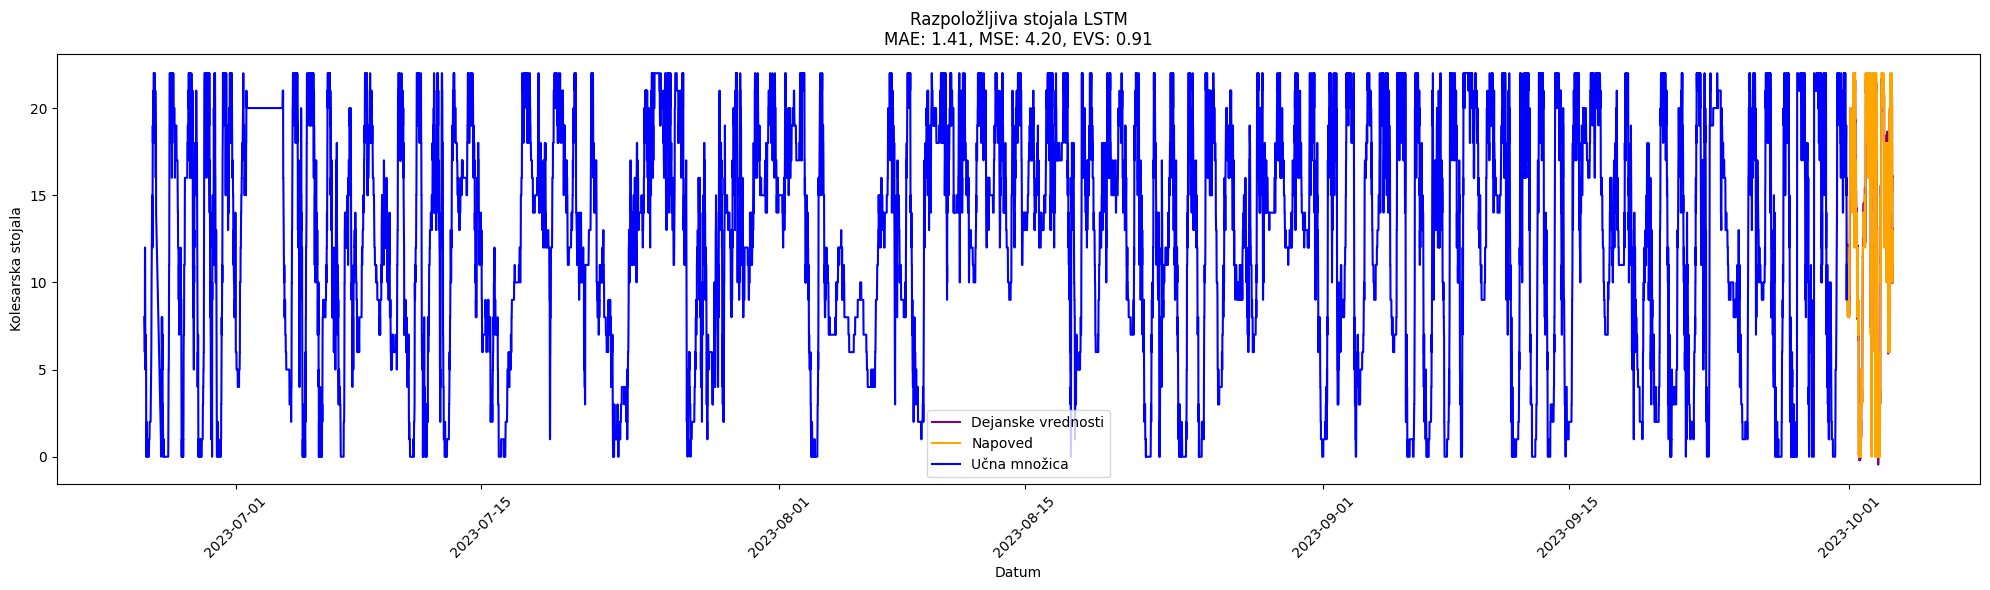

In [ ]:
dates = all_data['date'][:-look_back][-len(y_test):]
train_dates =  all_data['date'][:len(train_data)]


print(dates.shape)
# Function to plot a comparison between actual values and predictions for a given model
def plot_comparison(train_dates, train_data, test_dates, y_pred_inverse, y_test_inverse, model_name, color1, color2, mae, mse, evs):
    plt.figure(figsize=(20, 6))
    plt.title(f'Razpoložljiva stojala {model_name}\nMAE: {mae:.2f}, MSE: {mse:.2f}, EVS: {evs:.2f}')
    plt.xlabel('Datum')
    plt.ylabel('Kolesarska stojala')
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_inverse, color='purple', label='Dejanske vrednosti')
    plt.plot(test_dates, y_pred_inverse, color=color2, label=f'Napoved')
    plt.plot(train_dates, train_data, color=color1, label='Učna množica')
    plt.legend()
    plt.tight_layout()
    plt.show()



# Plotting LSTM predictions
plot_comparison(
    train_dates,
    train_data[:,0],
    dates,
    y_test_true,
    y_test_pred_lstm_adv,
    'LSTM',
    'blue',
    'orange',
    lstm_mae_adv,
    lstm_mse_adv,
    lstm_evs_adv
)

Epoch 1/30
467/467 [==============================] - 7s 9ms/step - loss: 0.0313 - val_loss: 0.0107
Epoch 2/30
467/467 [==============================] - 3s 7ms/step - loss: 0.0054 - val_loss: 0.0080
Epoch 3/30
467/467 [==============================] - 3s 7ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 4/30
467/467 [==============================] - 4s 8ms/step - loss: 0.0033 - val_loss: 0.0070
Epoch 5/30
467/467 [==============================] - 3s 7ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 6/30
467/467 [==============================] - 4s 8ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 7/30
467/467 [==============================] - 4s 8ms/step - loss: 0.0029 - val_loss: 0.0048
Epoch 8/30
467/467 [==============================] - 3s 7ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 9/30
467/467 [==============================] - 3s 7ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 10/30
467/467 [==============================] - 3s 7ms/step - loss: 0.0027 - val_loss: 0.0048

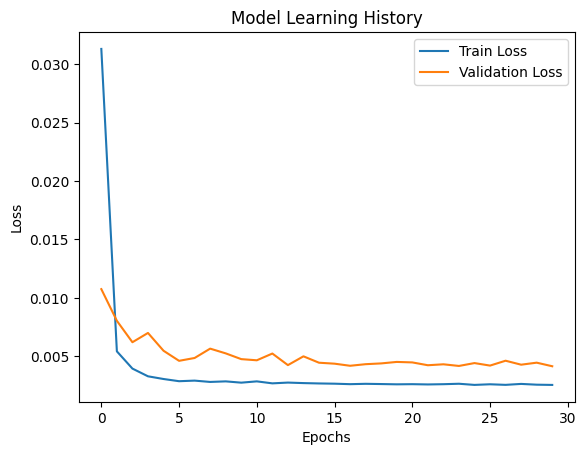

In [ ]:
lstm_model_final = build_lstm_model(input_shape)
train_and_plot_model(lstm_model_final, X_final, y_final, epochs=30)

In [ ]:
lstm_model_final.save("../models/lstm_model_final.h5")

In [ ]:
joblib.dump(stands_scaler, '../models/scalers/stands_scaler.joblib')
joblib.dump(other_scaler, '../models/scalers/other_scaler.joblib')

['../models/scalers/other_scaler.joblib']